# Importing PySpark and Reading the Dataset

## Importing PySpark

In [85]:
from pyspark.sql import SparkSession, DataFrame

spark = SparkSession.builder.appName("Task02").getOrCreate()

print(spark)

In [86]:
spark.version

'3.5.5'

## Reading the Dataset

In [87]:
import_file_path = "gold_prices.csv"

df = spark.read.csv(import_file_path, header=True, inferSchema=True)
df.show(5)

+----------+---------+----------+
|      Date|Buy Price|Sell Price|
+----------+---------+----------+
|2009-08-01|    21.13|     21.19|
|2009-08-02|    21.13|     21.19|
|2009-08-03|    21.13|     21.19|
|2009-08-04|    21.13|     21.19|
|2009-08-05|    21.13|     21.19|
+----------+---------+----------+
only showing top 5 rows



In [88]:
df.describe().show()

+-------+------------------+------------------+
|summary|         Buy Price|        Sell Price|
+-------+------------------+------------------+
|  count|              5565|              5565|
|   mean|  45.5656999101527|46.017667565139305|
| stddev|14.892834946578136|15.353833530564659|
|    min|             21.13|             21.19|
|    max|              89.0|              91.3|
+-------+------------------+------------------+



In [89]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Buy Price: double (nullable = true)
 |-- Sell Price: double (nullable = true)



# Generating Samples

## Main Function

In [90]:
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler
import random


def generate_samples(dataset: DataFrame, cols_to_remove: list[str] = None,
                     n_days: int = 10, n_sample: int = 4000, random_state: int = None,
                     target_col: str = "Buy Price") -> DataFrame:
	"""
  A function to generate a sample dataframe from a dataset.

  :param dataset: Dataframe for sampling.
  :param cols_to_remove: List of irrelevant columns.
  :param n_days: Range of days prior to t, default is 10.
  :param n_sample: Number of samples to generate, default is 1000.
  :param random_state: Seed to set for consistent reproduction.
  :param target_col: Target column to collect.
  :return: Sample dataframe with n features.
  """

	"""
  Generating a list of random indices
  """
	if random_state is not None:
		random.seed(random_state)

	# Making sure it starts from a valid date to collect n_days previous rows
	population = range(n_days + 1, dataset.count() + 1)
	sample_indices = random.sample(population, n_sample)

	"""
  Collecting the buy price of previous lag_range number of days:
  - Generating a temporary column for indexing
  - Generate values for rows whose index is within sample_indices
  """
	samples = dataset
	features = []
	window = Window.orderBy("Date")
	index_col = "Index"
	samples = samples.withColumn(index_col, F.row_number().over(window))
	condition = F.col(index_col).isin(sample_indices)

	for i in range(1, n_days + 1):
		feature_col = f"t-{i}"
		features.append(feature_col)

		samples = samples.withColumn(
			feature_col,
			F.when(
				condition,
				F.lag(target_col, i, None).over(window)
			).otherwise(
				F.lit(None)
			)
		)

	"""
  Cleaning the dataset:
  - Dropping unnecessary columns as well as null.
  - Changing target_col column name to "Current {target_col}"
  """
	for col in cols_to_remove:
		if col not in features and col != target_col:
			samples = samples.drop(col)

	samples = samples.drop(index_col)
	samples = samples.withColumnRenamed(target_col, f"Current {target_col}")
	samples = samples.dropna()

	"""
  Transforming the sample dataframe by collecting feature
   columns into a single column named "Previous {target_col}(s)"
  """
	assembler = VectorAssembler(
		inputCols=features,
		outputCol=f"Previous {target_col}(s)",
	)

	samples = assembler.transform(samples)

	"""
  Dropping all the previous feature columns
  """
	for col in features:
		samples = samples.drop(col)

	return samples

In [91]:
sample_df = generate_samples(df, random_state=42, cols_to_remove=["Date", "Sell Price"])
# isCorrect = True
#
# while isCorrect:
# 	sample_df = generate_samples(
# 		df.limit(5),
# 		n_days=2,
# 		n_sample=3,
# 		random_state=42,
# 		cols_to_remove=["Date", "Sell Price"]
# 	)
#
# 	if sample_df.count() == 3:
# 		isCorrect = False

sample_df.show(5)

+-----------------+---------------------+
|Current Buy Price|Previous Buy Price(s)|
+-----------------+---------------------+
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
+-----------------+---------------------+
only showing top 5 rows



## Saving the Generated Samples

In [92]:
from pyspark.sql.types import StringType

# Converting the Dataframe to a suitable format to export
column_to_convert = "Previous Buy Price(s)"

df_for_csv = sample_df.withColumn(
	column_to_convert,
	F.col(column_to_convert).cast(StringType())
)

pandas_df = df_for_csv.coalesce(1).toPandas()

export_file_path = "generated_samples.csv"
pandas_df.to_csv(export_file_path, index=False)

print(f"Generated samples saved to {export_file_path}")

Generated samples saved to generated_samples.csv


# Training and Predicting

## Splitting the Training and Testing Sets

In [93]:
train_set, test_set = sample_df.randomSplit(weights=[0.7, 0.3], seed=2)

In [94]:
train_set.show(5)

+-----------------+---------------------+
|Current Buy Price|Previous Buy Price(s)|
+-----------------+---------------------+
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
+-----------------+---------------------+
only showing top 5 rows



In [95]:
test_set.show(5)

+-----------------+---------------------+
|Current Buy Price|Previous Buy Price(s)|
+-----------------+---------------------+
|            21.13| [21.13,21.13,21.1...|
|            21.13| [21.13,21.13,21.1...|
|            22.09| [22.07,22.04,22.0...|
|            22.19| [22.09,22.07,22.0...|
|            22.25| [22.19,22.09,22.0...|
+-----------------+---------------------+
only showing top 5 rows



## Training the Model

In [96]:
from pyspark.ml.regression import LinearRegression

lg = LinearRegression(
	featuresCol="Previous Buy Price(s)",
	labelCol="Current Buy Price",
	solver="l-bfgs",
)

lg_model = lg.fit(train_set)

## Making Predictions

In [97]:
predictions = (lg_model.transform(test_set)
               .withColumnRenamed("prediction", "Predicted Buy Price"))
predictions.show(5)

+-----------------+---------------------+-------------------+
|Current Buy Price|Previous Buy Price(s)|Predicted Buy Price|
+-----------------+---------------------+-------------------+
|            21.13| [21.13,21.13,21.1...|  21.12994910188006|
|            21.13| [21.13,21.13,21.1...|  21.12994910188006|
|            22.09| [22.07,22.04,22.0...| 22.113260386508433|
|            22.19| [22.09,22.07,22.0...| 22.082984247611883|
|            22.25| [22.19,22.09,22.0...| 22.187991777090367|
+-----------------+---------------------+-------------------+
only showing top 5 rows



# Evaluating the Model

In [98]:
def evaluate_model(dataset: DataFrame):
	"""
  A function to evaluate the model performance based on a given dataset.
  :param dataset: The dataframe for evaluation.
  :return: Dictionary of evaluation results using different metrics.
  """

	evaluation = lg_model.evaluate(dataset)

	metrics = {
		"Root Mean Squared Error": evaluation.rootMeanSquaredError,
		"Mean Squared Error": evaluation.meanSquaredError,
		"R2": evaluation.r2,
		"Mean Absolute Error": evaluation.meanAbsoluteError,
		"Explained Variance": evaluation.explainedVariance,
		"R2 Adjusted": evaluation.r2adj,
	}

	max_len = 24

	for metric in metrics.keys():
		print(f"{metric:<{max_len}}: {metrics.get(metric):.4f}")

	return metrics

## On the Training Set

In [99]:
train_evaluation = evaluate_model(train_set)

Root Mean Squared Error : 0.2672
Mean Squared Error      : 0.0714
R2                      : 0.9997
Mean Absolute Error     : 0.1351
Explained Variance      : 217.3482
R2 Adjusted             : 0.9997


## On the Testing Set

In [100]:
test_evaluation = evaluate_model(test_set)

Root Mean Squared Error : 0.3304
Mean Squared Error      : 0.1092
R2                      : 0.9995
Mean Absolute Error     : 0.1434
Explained Variance      : 219.7607
R2 Adjusted             : 0.9995


# Illustration Charts

## Line Chart

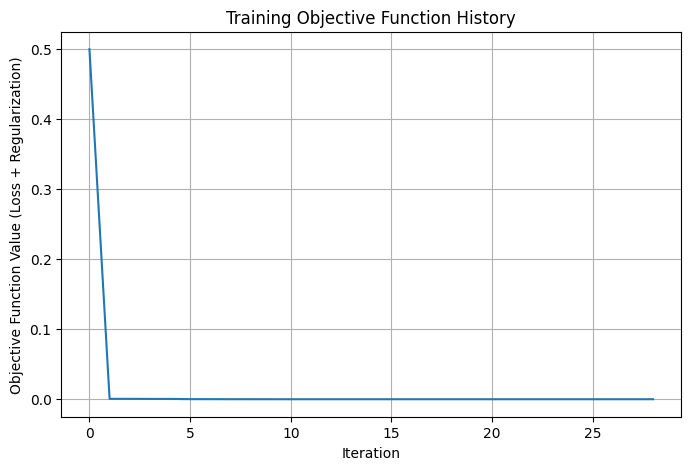

In [101]:
import matplotlib.pyplot as plt

loss_history = lg_model.summary.objectiveHistory

if loss_history:
	plt.figure(figsize=(8, 5))
	plt.plot(loss_history)
	plt.title('Training Objective Function History')
	plt.xlabel('Iteration')
	plt.ylabel('Objective Function Value (Loss + Regularization)')
	plt.grid(True)
	plt.show()

## Bar Chart

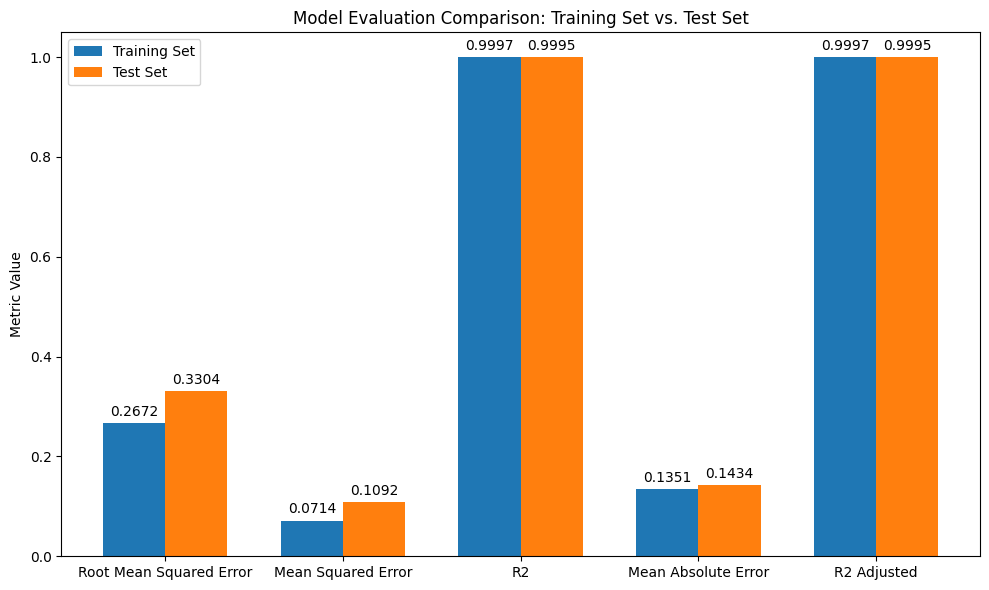

In [102]:
import numpy as np

train_evaluation_copy = train_evaluation.copy()
test_evaluation_copy = test_evaluation.copy()

train_var = train_evaluation_copy.pop("Explained Variance")
test_var = test_evaluation_copy.pop("Explained Variance")

evaluation_metrics = train_evaluation_copy.keys()

x = np.arange(len(evaluation_metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width / 2,
                train_evaluation_copy.values(),
                width,
                label='Training Set')
rects2 = ax.bar(x + width / 2,
                test_evaluation_copy.values(),
                width,
                label='Test Set')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Metric Value')
ax.set_title('Model Evaluation Comparison: Training Set vs. Test Set')
ax.set_xticks(x)
ax.set_xticklabels(evaluation_metrics)
ax.legend()

# Optional: Add labels on top of bars for clarity
ax.bar_label(rects1, padding=3, fmt='%.4f')
ax.bar_label(rects2, padding=3, fmt='%.4f')

# Adjust the layout to prevent labels from overlapping
fig.tight_layout()
plt.show()

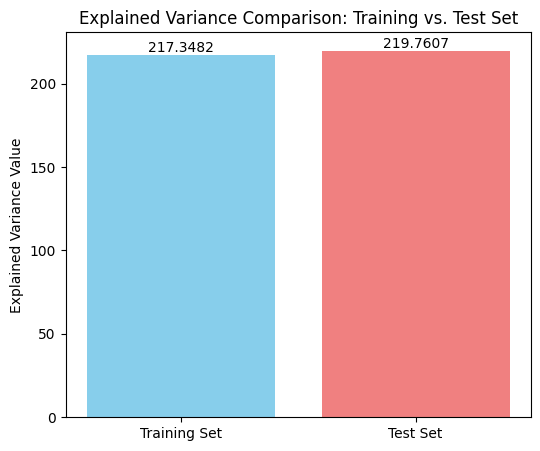

In [103]:
metric_name = "Explained Variance"

sets = ['Training Set', 'Test Set']
values = [train_var, test_var]

plt.figure(figsize=(6, 5))
bars = plt.bar(sets, values, color=['skyblue', 'lightcoral'])

plt.ylabel(f'{metric_name} Value')
plt.title(f'{metric_name} Comparison: Training vs. Test Set')
plt.bar_label(bars, fmt='%.4f')

plt.show()